# Artificial Neural Networks and Deep Learning - Homework 2


## 🌐 Connect Colab to Google Drive

In [1]:
# from google.colab import drive

# drive.mount("/gdrive")
# %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2024-12-04 22:36:07.240556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 22:36:07.282107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 22:36:07.294670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 22:36:07.324781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 22:36:09.302491: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0
Keras version: 3.4.1
GPU devices: 1


I0000 00:00:1733348172.739140  317157 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733348172.828955  317157 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733348172.830609  317157 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## ⏳ Load and prepare the Data

In [3]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [4]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [5]:
# Remove outliers (containing aliens)
outliers = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# Print the new shape
print(f"Training X shape after outlier removal: {X_train.shape}")
print(f"Training y shape after outlier removal: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape after outlier removal: (2505, 64, 128, 1)
Training y shape after outlier removal: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [6]:
# Split into training and validation (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=seed, test_size=0.2
)

In [7]:
category_map = {
    0: 0,  # background
    1: 1,  # soil
    2: 2,  # bedrock
    3: 3,  # sand
    4: 4,  # big rock
}


def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )
    return table.lookup(label)

In [8]:
@tf.function
def random_flip_h(image, label):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label

@tf.function
def random_flip_v(image, label):
    """Consistent random vertical flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(label), lambda: label
    )
    return image, label

@tf.function
def random_brightness(image):
    delta = tf.random.uniform([])
    delta_thresh = 0.1
    image = tf.cond(
        delta < 3*delta_thresh, lambda: tf.image.adjust_brightness(image, delta=delta), lambda: image
    )
    return image

@tf.function
def random_contrast(image):
    factor = tf.random.uniform([])
    factor_thresh = 2
    image = tf.cond(
        factor < factor_thresh/6, lambda: tf.image.adjust_contrast(image, contrast_factor=factor), lambda: image
    )
    return image

@tf.function
def augmentation(image, label, seed=None):
    image, label = random_flip_h(image, label)
    #image, label = random_flip_v(image, label)
    #image = random_brightness(image)
    #image = random_contrast(image)
    return image, label

In [9]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Add an axis to labels
    new_labels = labels[..., np.newaxis]

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, new_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [10]:
batch_size = 32

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train,
    y_train.astype("int32"),
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed,
)

val_dataset = make_dataset(
    X_val, y_val.astype("int32"), batch_size=batch_size, shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...


I0000 00:00:1733348176.886135  317157 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733348176.887901  317157 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733348176.889721  317157 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733348177.121184  317157 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Analyze the data

Visualizing examples from the training set:


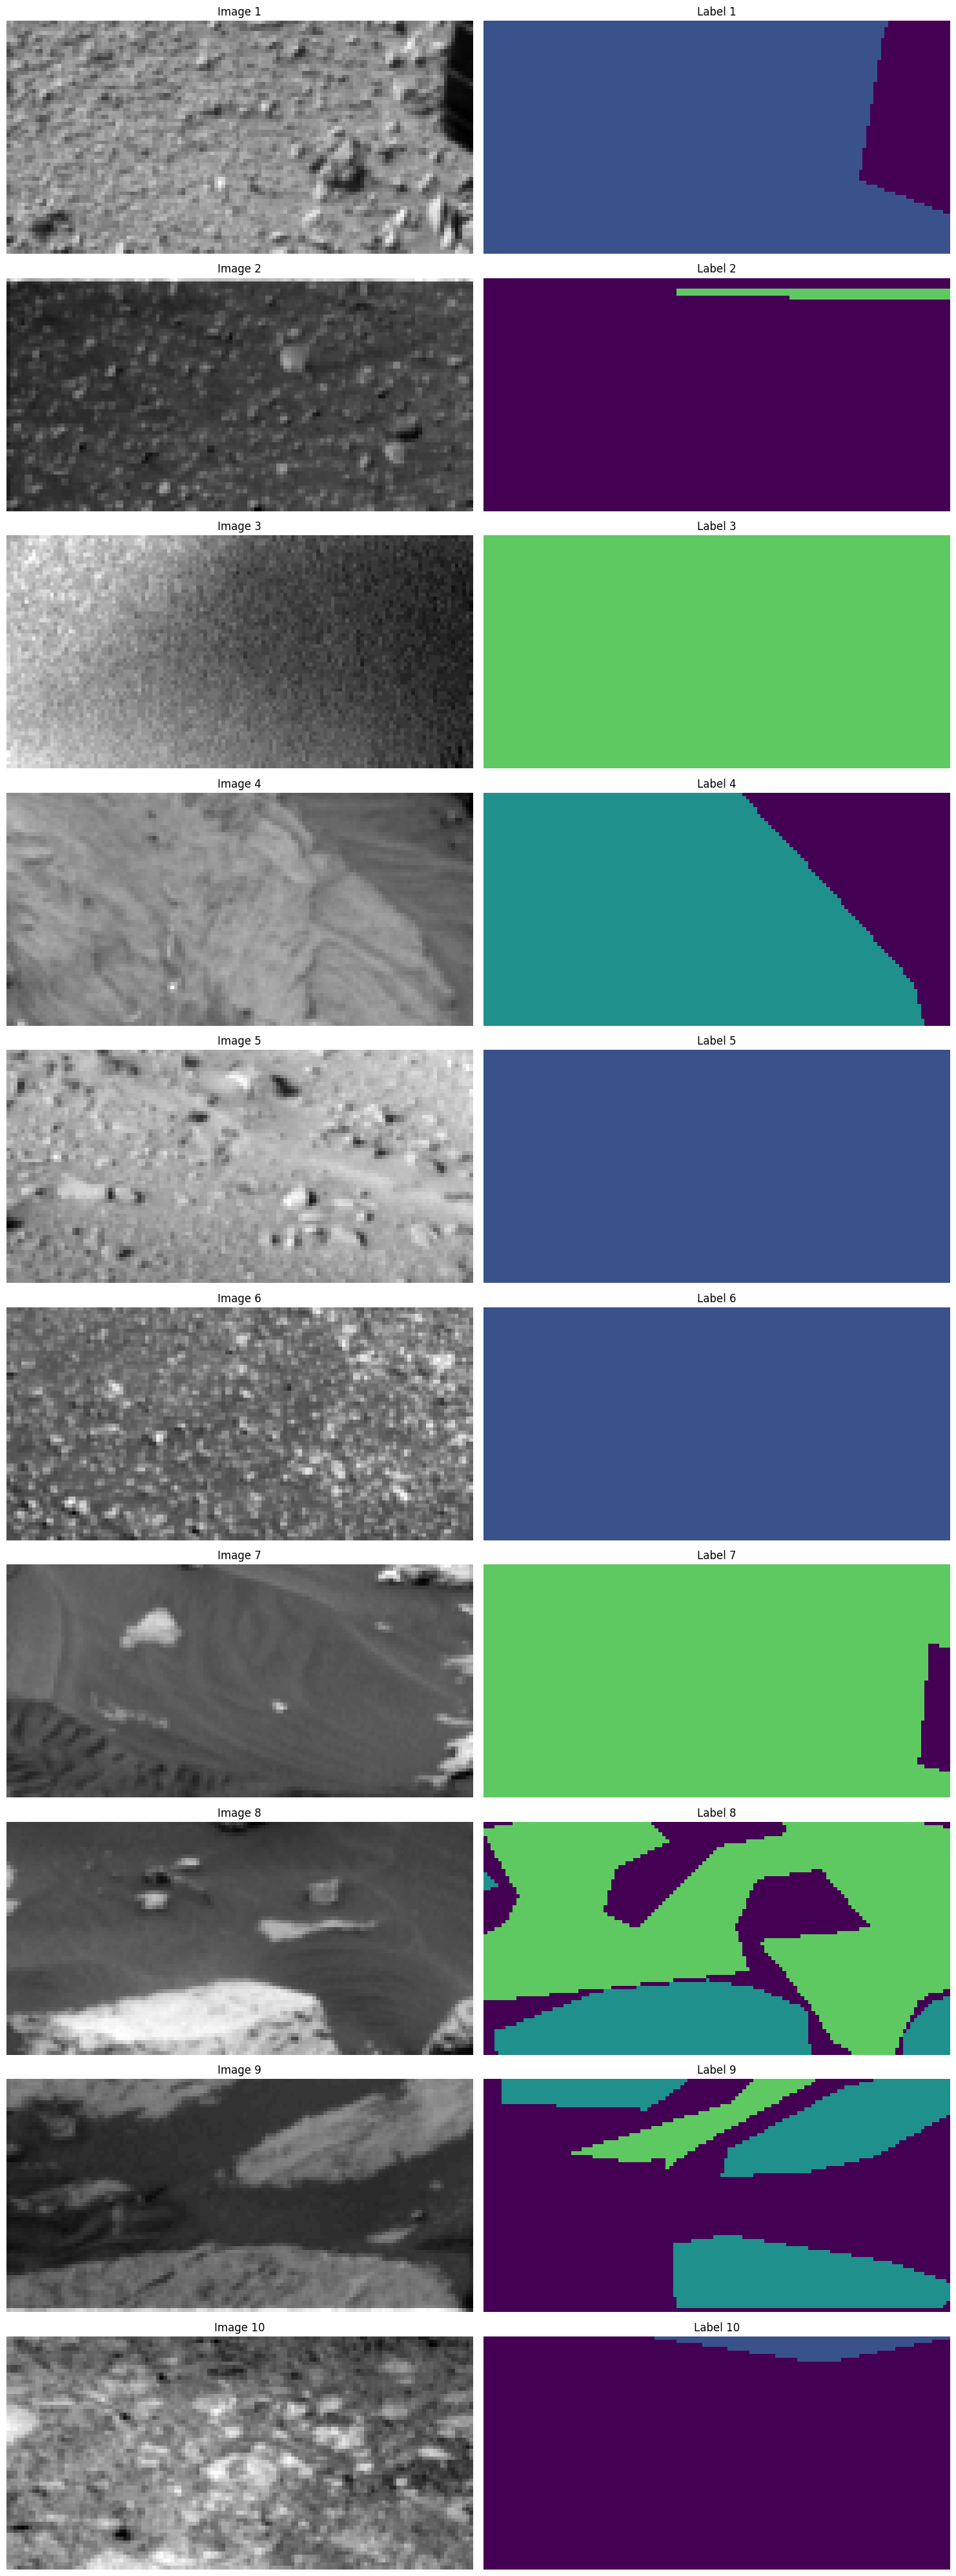

In [11]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def plot_sample_batch(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(images))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(images[j], cmap="grey")
        plt.title(f"Image {j+1}")
        plt.axis("off")

        # Plot colored label
        plt.subplot(num_samples, 2, j * 2 + 2)
        colored_label = apply_colormap(labels[j], colormap)
        plt.imshow(colored_label)
        plt.title(f"Label {j+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

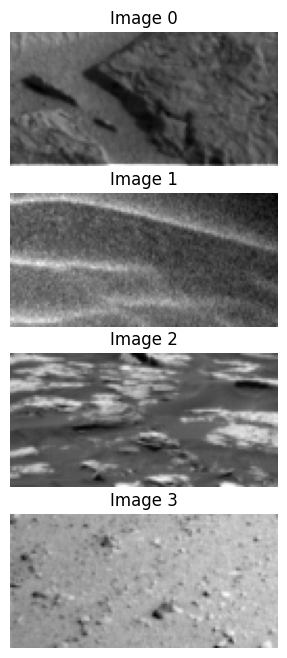

In [12]:
# Visualize examples from the test set.
num_samples = 4
plt.figure(figsize=(15, 2 * num_samples))

colormap = create_segmentation_colormap(num_classes)

for j in range(min(num_samples, len(X_test))):
    plt.subplot(num_samples, 1, j + 1)
    plt.imshow(X_test[j], cmap="grey")
    plt.title(f"Image {j}")
    plt.axis("off")

## 🛠️ Define the model

In [13]:
def unet_block(
    input_tensor, filters, kernel_size=3, activation="relu", stack=2, name=""
):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding="same",
            name=name + "conv" + str(i + 1),
        )(x)
        x = tfkl.BatchNormalization(name=name + "bn" + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + "activation" + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [14]:
# Define a Residual block with configurable parameters (currently unused, but
# used in older models). Note that a modified version of this block is used in
# the final model, by combining it with the inception block.
def residual_unet_block(x, filters, kernel_size=3, padding='same',
                        downsample=False, activation='relu', stack=1, name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # First convolutional block with Batch Normalisation and activation.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [15]:
# Define the Inception block with batch normalization (BN) and with multiple
# convolution paths and optional downsampling.
def inception_block_bn(x, filters, padding='same',
                       downsample=False, activation='relu', stack=2, name='inception'):
    # This inception block consists of a 1x1 convolution path, a 3x3 convolution
    # path, a 5x5 convolution path, and a pooling path. The paths are then
    # concatenated to form the final block output.
    # The reason for using multiple paths is to allow the model to learn
    # different features at different scales, and to increase the model's
    # capacity without increasing the number of parameters too much.
    # The downsampling (pooling) is not mandatory.

    # Loop through specified stack layers for multiple inception paths.
    for s in range(stack):
        # 1x1 convolution path with batch normalization and activation.
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)

        # 3x3 convolution path with initial reduction layer.
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        conv3_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(conv3_reduce)
        conv3_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(conv3_reduce)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)

        # 5x5 convolution path with initial reduction layer.
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        conv5_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(conv5_reduce)
        conv5_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(conv5_reduce)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)

        # Pooling path with projection for spatial dimensionality reduction.
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(pool_proj)

        # Concatenate all paths to form the final block output.
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [16]:
# Define the a residual block using an inception block instead of the 
# convolutional path. This mixed block is used in the final model, and it
# combines the benefits of both residual and inception blocks. We believe
# that the residual and inception blocks are complementary, as their guesses
# don't seem to perfectly overlap. See the report for more details.
def inception_residual_unet(x, filters, padding='same', downsample=False, 
                            activation='relu', stack=2, inception_stack=2,
                            name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # Create the inception block.
        x = inception_block_bn(x, filters, padding, downsample=False, activation=activation,
                               stack=inception_stack, name=f'{name}_inception_{s}')

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [17]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Downsampling path
    down_block_1 = inception_residual_unet(input_layer, 96, name="down_block1_")
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = inception_residual_unet(d1, 192, name="down_block2_")
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = inception_residual_unet(d2, 384, name="bottleneck")

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = inception_residual_unet(u1, 192, name="up_block1_")

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = inception_residual_unet(u2, 96, name="up_block2_")

    # Output Layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation="softmax",
        name="output_layer",
    )(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="UNet")
    return model

In [18]:
# Define parameters
epochs = 1000
patience = 20
learning_rate = 1e-4

In [19]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
try:
    tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)
except:
    print("Model too complex to plot!")

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        24 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        16 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        32 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Activation)      │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Activation)      │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ input_layer[0… │   -   │
│ (MaxPooling2D)    │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │     2,616 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │     4,824 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   - 

 Total params: 1,700,201 (6.49 MB)

 Trainable params: 1,689,001 (6.44 MB)

 Non-trainable params: 11,200 (43.75 KB)

## Train the model

In [20]:
# Define custom Mean Intersection Over Union metric
@tfk.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(
        self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None
    ):
        super(MeanIntersectionOverUnion, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            label = apply_category_mapping(label)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="grey")
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

In [21]:
# Define a custom loss
class CustomLoss(tfk.losses.Loss):
    def __init__(self, alpha, name='custom_loss', **kwargs):
        super(CustomLoss, self).__init__(name=name, **kwargs)
        self.alpha = alpha
        self.focal = tfk.losses.CategoricalFocalCrossentropy()
        self.dice = tfk.losses.Dice()

    def call(self, y_true, y_pred):
        # Calculate the cross-entropy loss
        return (1-self.alpha)*self.focal.call(y_true, y_pred)+self.alpha*self.dice.call(y_true, y_pred)

In [22]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=[
        "accuracy",
        MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0]),
    ],
)
print("Model compiled!")

Compiling model...
Model compiled!


In [23]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_iou", mode="max", patience=patience, restore_best_weights=True
)

image, label = val_dataset.take(1).get_single_element()
viz_callback = VizCallback(image[11:12, ...], label[11:12, ...])

reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=patience / 2, factor=0.1, min_lr=learning_rate / 100
)

callbacks = [early_stopping, viz_callback, reduce_lr_callback]

Epoch 1/1000


I0000 00:00:1733348312.783334  317373 service.cc:146] XLA service 0x781d4c00a8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733348312.783366  317373 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-04 22:38:36.879381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1733348330.439159  317373 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-04 22:38:57.878951: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1733348350.916393  317373 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.3928 - loss: 1.5734 - mean_iou: 0.1960

W0000 00:00:1733348463.470479  317368 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1733348481.087515  317368 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733348481.384462  317368 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733348482.306916  317368 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733348482.600654  317368 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:17

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3938 - loss: 1.5702 - mean_iou: 0.1966   

W0000 00:00:1733348560.926852  317373 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733348573.092278  317368 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


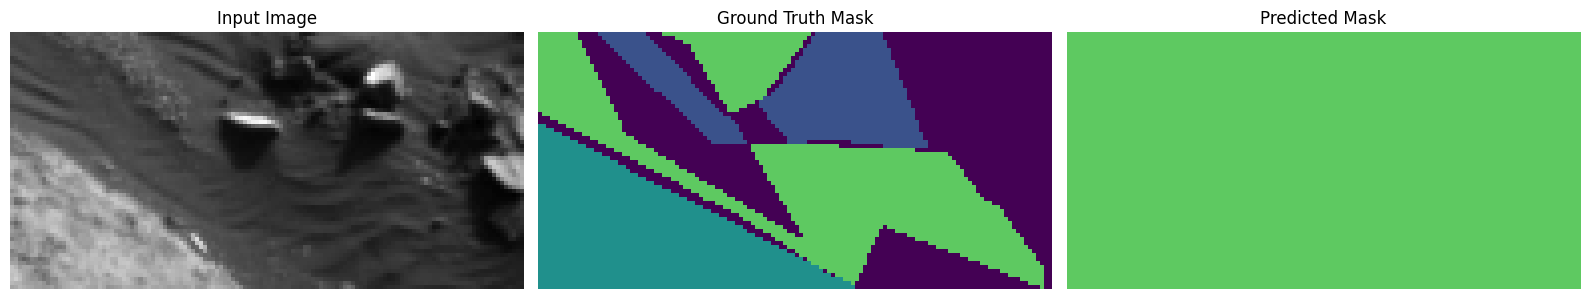

63/63 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.3949 - loss: 1.5670 - mean_iou: 0.1971 - val_accuracy: 0.1979 - val_loss: 1.7248 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 515ms/step - accuracy: 0.5546 - loss: 1.1019 - mean_iou: 0.2909 - val_accuracy: 0.1979 - val_loss: 2.0733 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - accuracy: 0.6088 - loss: 0.9874 - mean_iou: 0.3312 - val_accuracy: 0.1979 - val_loss: 2.3152 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 528ms/step - accuracy: 0.6278 - loss: 0.9452 - mean_iou: 0.3415 - val_accuracy: 0.1979 - val_loss: 2.6602 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.6422 - loss: 0.9073 - mean_iou: 0.3567 - val_accuracy: 0.1979 - val_loss: 3.0357 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 6/10

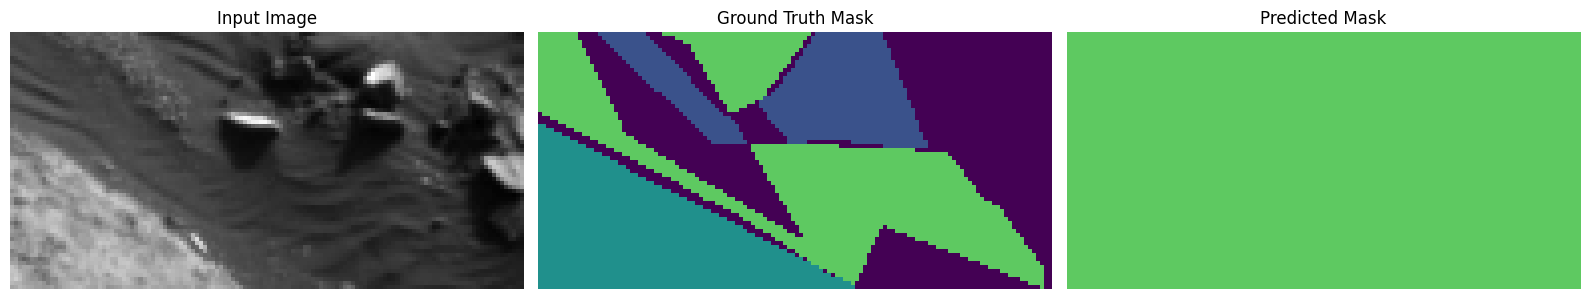

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 544ms/step - accuracy: 0.6622 - loss: 0.8635 - mean_iou: 0.3740 - val_accuracy: 0.2002 - val_loss: 2.8817 - val_mean_iou: 0.0536 - learning_rate: 1.0000e-04
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 545ms/step - accuracy: 0.6720 - loss: 0.8422 - mean_iou: 0.3821 - val_accuracy: 0.2642 - val_loss: 2.2627 - val_mean_iou: 0.0909 - learning_rate: 1.0000e-04
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.6814 - loss: 0.8211 - mean_iou: 0.3924 - val_accuracy: 0.4086 - val_loss: 1.6230 - val_mean_iou: 0.1867 - learning_rate: 1.0000e-04
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.6861 - loss: 0.8128 - mean_iou: 0.3937 - val_accuracy: 0.5515 - val_loss: 1.2008 - val_mean_iou: 0.2702 - learning_rate: 1.0000e-04
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.6828 - loss: 0.8160 - mean_iou: 0.3928 - val_accuracy: 0.6467 - val_loss: 0.9153 - val_mean_iou: 0.3586 - learning_rate: 1.0000e-04
Epoch 1

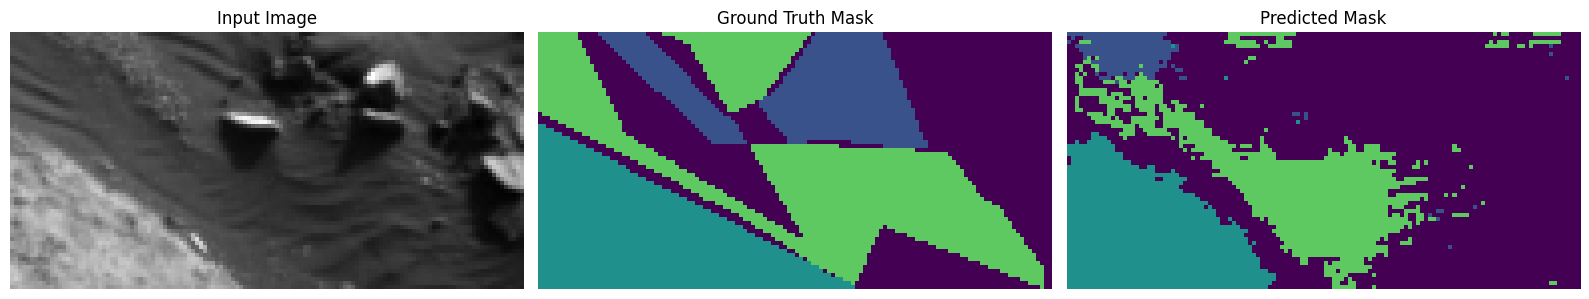

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step - accuracy: 0.7054 - loss: 0.7667 - mean_iou: 0.4098 - val_accuracy: 0.6744 - val_loss: 0.8438 - val_mean_iou: 0.3870 - learning_rate: 1.0000e-04
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 547ms/step - accuracy: 0.7011 - loss: 0.7734 - mean_iou: 0.4054 - val_accuracy: 0.6770 - val_loss: 0.8701 - val_mean_iou: 0.3801 - learning_rate: 1.0000e-04
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7065 - loss: 0.7467 - mean_iou: 0.4077 - val_accuracy: 0.7028 - val_loss: 0.7826 - val_mean_iou: 0.4009 - learning_rate: 1.0000e-04
Epoch 14/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.7181 - loss: 0.7391 - mean_iou: 0.4239 - val_accuracy: 0.6786 - val_loss: 0.8621 - val_mean_iou: 0.3823 - learning_rate: 1.0000e-04
Epoch 15/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7282 - loss: 0.7078 - mean_iou: 0.4390 - val_accuracy: 0.5988 - val_loss: 1.2081 - val_mean_iou: 0.3068 - learning_rate: 1.0000e-04
Epoc

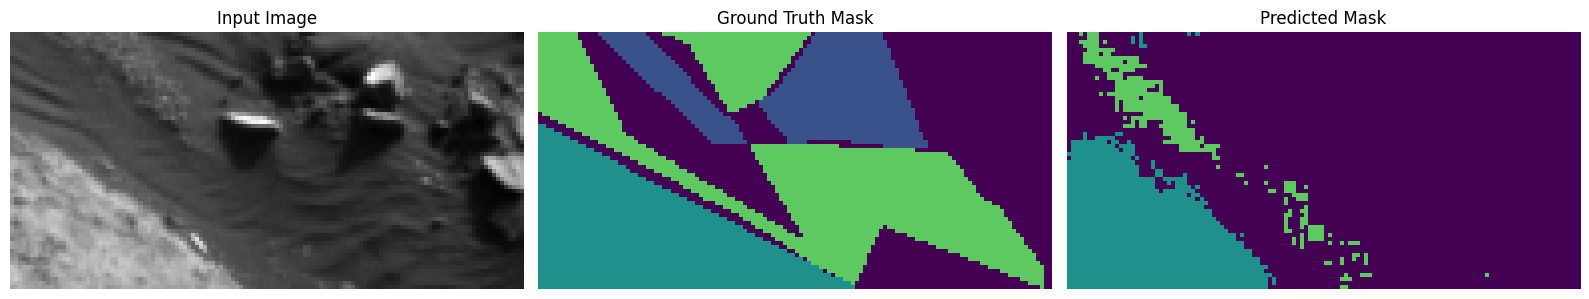

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 557ms/step - accuracy: 0.7244 - loss: 0.7177 - mean_iou: 0.4295 - val_accuracy: 0.6798 - val_loss: 0.8554 - val_mean_iou: 0.3781 - learning_rate: 1.0000e-04
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 555ms/step - accuracy: 0.7278 - loss: 0.7073 - mean_iou: 0.4301 - val_accuracy: 0.7135 - val_loss: 0.7640 - val_mean_iou: 0.4085 - learning_rate: 1.0000e-04
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7330 - loss: 0.7010 - mean_iou: 0.4446 - val_accuracy: 0.6784 - val_loss: 0.9066 - val_mean_iou: 0.3791 - learning_rate: 1.0000e-04
Epoch 19/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.7332 - loss: 0.6966 - mean_iou: 0.4334 - val_accuracy: 0.6422 - val_loss: 1.0495 - val_mean_iou: 0.3428 - learning_rate: 1.0000e-04
Epoch 20/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.7334 - loss: 0.7004 - mean_iou: 0.4347 - val_accuracy: 0.7123 - val_loss: 0.7936 - val_mean_iou: 0.4064 - learning_rate: 1.0000e-04
Epoc

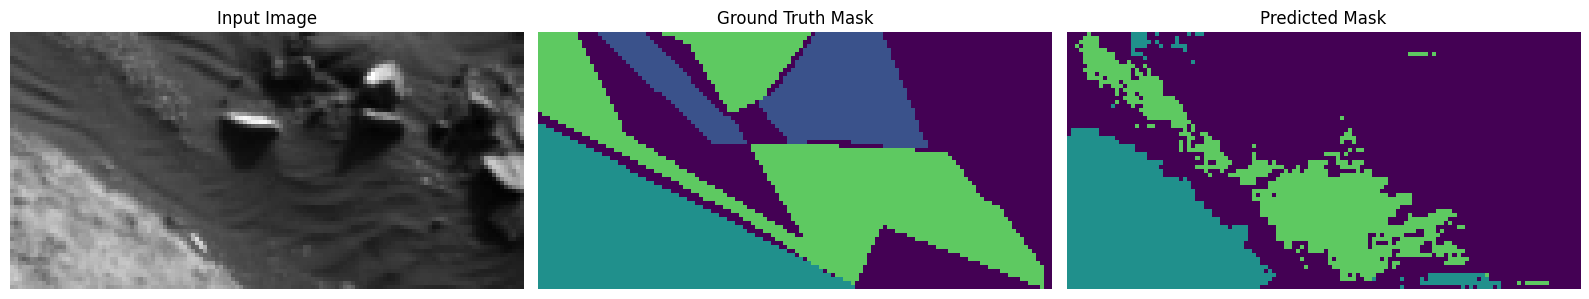

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 559ms/step - accuracy: 0.7410 - loss: 0.6790 - mean_iou: 0.4436 - val_accuracy: 0.7079 - val_loss: 0.7888 - val_mean_iou: 0.4021 - learning_rate: 1.0000e-04
Epoch 22/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7402 - loss: 0.6764 - mean_iou: 0.4470 - val_accuracy: 0.6764 - val_loss: 0.9038 - val_mean_iou: 0.3711 - learning_rate: 1.0000e-04
Epoch 23/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7429 - loss: 0.6655 - mean_iou: 0.4401 - val_accuracy: 0.7128 - val_loss: 0.7728 - val_mean_iou: 0.4072 - learning_rate: 1.0000e-04
Epoch 24/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7502 - loss: 0.6526 - mean_iou: 0.4509 - val_accuracy: 0.6830 - val_loss: 0.9045 - val_mean_iou: 0.3765 - learning_rate: 1.0000e-04
Epoch 25/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7525 - loss: 0.6423 - mean_iou: 0.4517 - val_accuracy: 0.7033 - val_loss: 0.8052 - val_mean_iou: 0.3968 - learning_rate: 1.0000e-04
Epoc

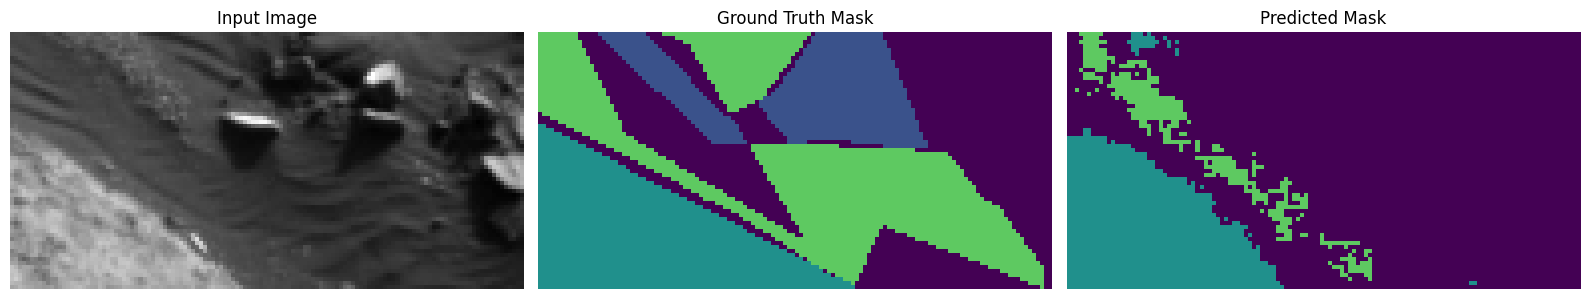

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 561ms/step - accuracy: 0.7493 - loss: 0.6493 - mean_iou: 0.4492 - val_accuracy: 0.6408 - val_loss: 1.0076 - val_mean_iou: 0.3373 - learning_rate: 1.0000e-04
Epoch 27/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7581 - loss: 0.6304 - mean_iou: 0.4614 - val_accuracy: 0.6317 - val_loss: 1.0120 - val_mean_iou: 0.3352 - learning_rate: 1.0000e-04
Epoch 28/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 557ms/step - accuracy: 0.7577 - loss: 0.6292 - mean_iou: 0.4601 - val_accuracy: 0.7467 - val_loss: 0.6624 - val_mean_iou: 0.4436 - learning_rate: 1.0000e-05
Epoch 29/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 555ms/step - accuracy: 0.7749 - loss: 0.5850 - mean_iou: 0.4844 - val_accuracy: 0.7508 - val_loss: 0.6505 - val_mean_iou: 0.4485 - learning_rate: 1.0000e-05
Epoch 30/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.7749 - loss: 0.5868 - mean_iou: 0.4760 - val_accuracy: 0.7506 - val_loss: 0.6516 - val_mean_iou: 0.4475 - learning_rate: 1.0000e-05
Epoc

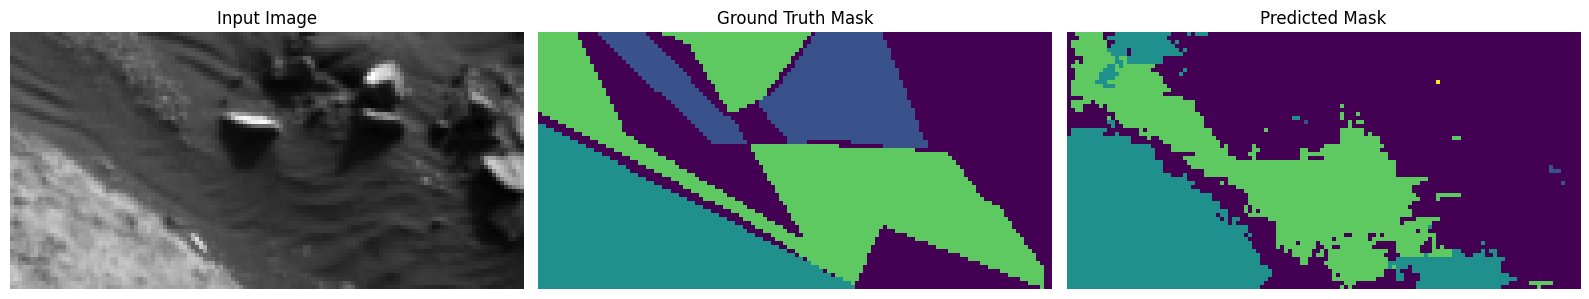

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 566ms/step - accuracy: 0.7786 - loss: 0.5728 - mean_iou: 0.4819 - val_accuracy: 0.7527 - val_loss: 0.6509 - val_mean_iou: 0.4499 - learning_rate: 1.0000e-05
Epoch 32/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 557ms/step - accuracy: 0.7755 - loss: 0.5782 - mean_iou: 0.4740 - val_accuracy: 0.7526 - val_loss: 0.6512 - val_mean_iou: 0.4511 - learning_rate: 1.0000e-05
Epoch 33/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.7803 - loss: 0.5696 - mean_iou: 0.4803 - val_accuracy: 0.7530 - val_loss: 0.6510 - val_mean_iou: 0.4486 - learning_rate: 1.0000e-05
Epoch 34/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7783 - loss: 0.5702 - mean_iou: 0.4847 - val_accuracy: 0.7512 - val_loss: 0.6528 - val_mean_iou: 0.4449 - learning_rate: 1.0000e-05
Epoch 35/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7844 - loss: 0.5648 - mean_iou: 0.4893 - val_accuracy: 0.7530 - val_loss: 0.6474 - val_mean_iou: 0.4491 - learning_rate: 1.0000e-05
Epoc

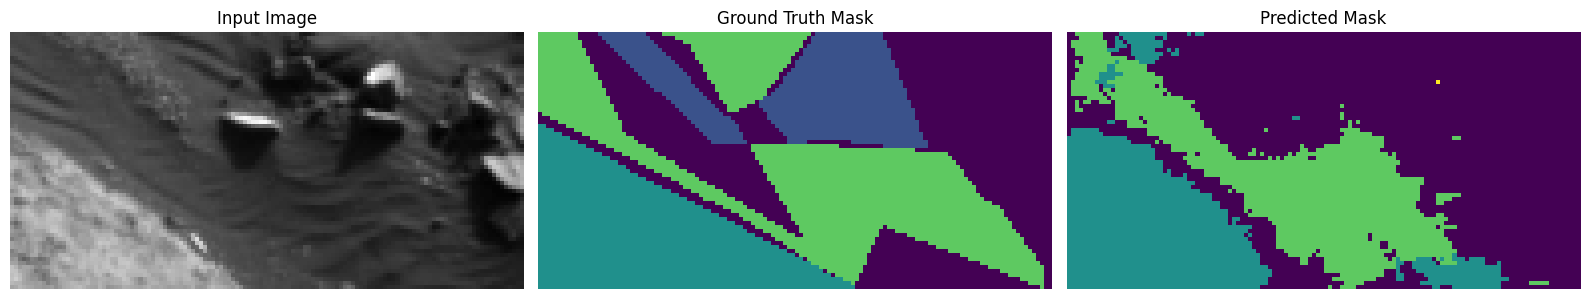

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 558ms/step - accuracy: 0.7786 - loss: 0.5720 - mean_iou: 0.4848 - val_accuracy: 0.7535 - val_loss: 0.6467 - val_mean_iou: 0.4479 - learning_rate: 1.0000e-05
Epoch 37/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 556ms/step - accuracy: 0.7804 - loss: 0.5673 - mean_iou: 0.4839 - val_accuracy: 0.7559 - val_loss: 0.6441 - val_mean_iou: 0.4533 - learning_rate: 1.0000e-05
Epoch 38/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7802 - loss: 0.5667 - mean_iou: 0.4817 - val_accuracy: 0.7544 - val_loss: 0.6462 - val_mean_iou: 0.4491 - learning_rate: 1.0000e-05
Epoch 39/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7897 - loss: 0.5463 - mean_iou: 0.4872 - val_accuracy: 0.7530 - val_loss: 0.6496 - val_mean_iou: 0.4486 - learning_rate: 1.0000e-05
Epoch 40/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step - accuracy: 0.7796 - loss: 0.5675 - mean_iou: 0.4802 - val_accuracy: 0.7528 - val_loss: 0.6513 - val_mean_iou: 0.4487 - learning_rate: 1.0000e-05
Epoc

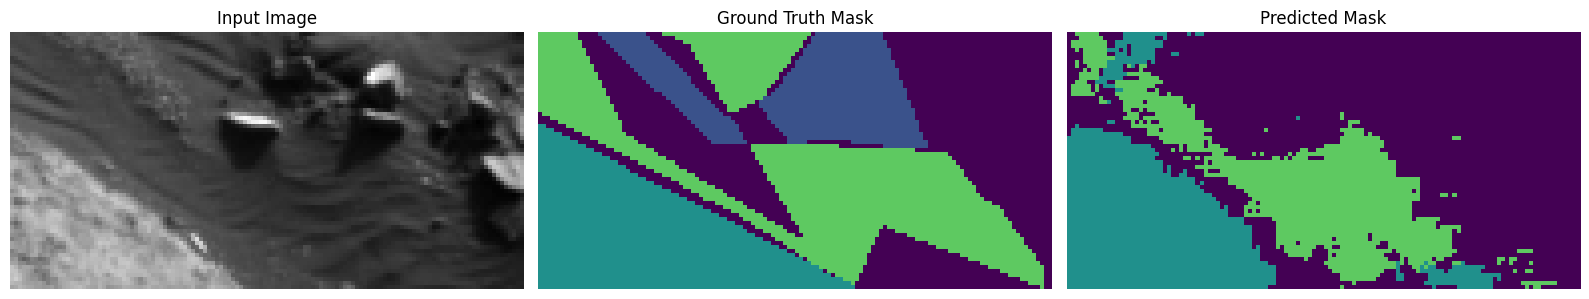

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 561ms/step - accuracy: 0.7782 - loss: 0.5715 - mean_iou: 0.4777 - val_accuracy: 0.7552 - val_loss: 0.6476 - val_mean_iou: 0.4500 - learning_rate: 1.0000e-05
Epoch 42/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7800 - loss: 0.5681 - mean_iou: 0.4804 - val_accuracy: 0.7551 - val_loss: 0.6440 - val_mean_iou: 0.4503 - learning_rate: 1.0000e-05
Epoch 43/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.7843 - loss: 0.5560 - mean_iou: 0.4800 - val_accuracy: 0.7531 - val_loss: 0.6494 - val_mean_iou: 0.4481 - learning_rate: 1.0000e-05
Epoch 44/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.7864 - loss: 0.5522 - mean_iou: 0.4896 - val_accuracy: 0.7538 - val_loss: 0.6475 - val_mean_iou: 0.4501 - learning_rate: 1.0000e-05
Epoch 45/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.7847 - loss: 0.5585 - mean_iou: 0.4860 - val_accuracy: 0.7533 - val_loss: 0.6523 - val_mean_iou: 0.4487 - learning_rate: 1.0000e-05
Epoc

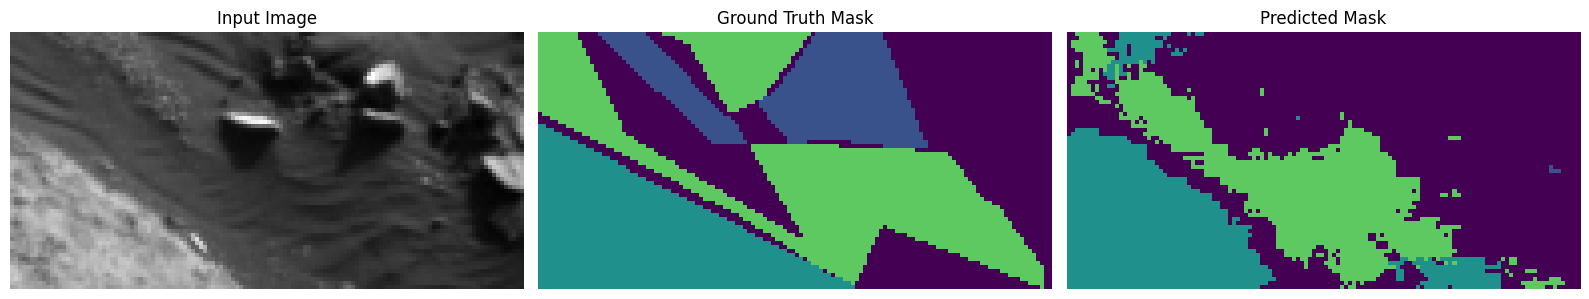

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 560ms/step - accuracy: 0.7864 - loss: 0.5453 - mean_iou: 0.4858 - val_accuracy: 0.7503 - val_loss: 0.6555 - val_mean_iou: 0.4434 - learning_rate: 1.0000e-05
Epoch 47/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7856 - loss: 0.5524 - mean_iou: 0.4860 - val_accuracy: 0.7560 - val_loss: 0.6437 - val_mean_iou: 0.4515 - learning_rate: 1.0000e-05
Epoch 48/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7780 - loss: 0.5675 - mean_iou: 0.4804 - val_accuracy: 0.7539 - val_loss: 0.6479 - val_mean_iou: 0.4476 - learning_rate: 1.0000e-05
Epoch 49/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7847 - loss: 0.5557 - mean_iou: 0.4857 - val_accuracy: 0.7534 - val_loss: 0.6490 - val_mean_iou: 0.4473 - learning_rate: 1.0000e-05
Epoch 50/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7846 - loss: 0.5523 - mean_iou: 0.4825 - val_accuracy: 0.7557 - val_loss: 0.6449 - val_mean_iou: 0.4485 - learning_rate: 1.0000e-05
Epoc

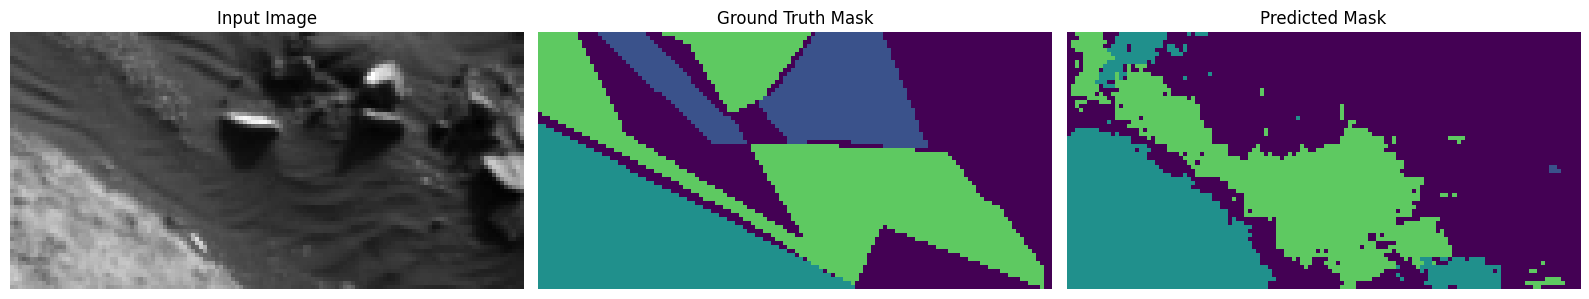

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 558ms/step - accuracy: 0.7870 - loss: 0.5470 - mean_iou: 0.4861 - val_accuracy: 0.7541 - val_loss: 0.6480 - val_mean_iou: 0.4491 - learning_rate: 1.0000e-05
Epoch 52/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.7905 - loss: 0.5360 - mean_iou: 0.4927 - val_accuracy: 0.7554 - val_loss: 0.6474 - val_mean_iou: 0.4495 - learning_rate: 1.0000e-05
Epoch 53/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7869 - loss: 0.5526 - mean_iou: 0.4886 - val_accuracy: 0.7568 - val_loss: 0.6419 - val_mean_iou: 0.4505 - learning_rate: 1.0000e-05
Epoch 54/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.7934 - loss: 0.5332 - mean_iou: 0.4901 - val_accuracy: 0.7540 - val_loss: 0.6458 - val_mean_iou: 0.4500 - learning_rate: 1.0000e-05
Epoch 55/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.7864 - loss: 0.5540 - mean_iou: 0.4866 - val_accuracy: 0.7545 - val_loss: 0.6467 - val_mean_iou: 0.4492 - learning_rate: 1.0000e-05
Epoc

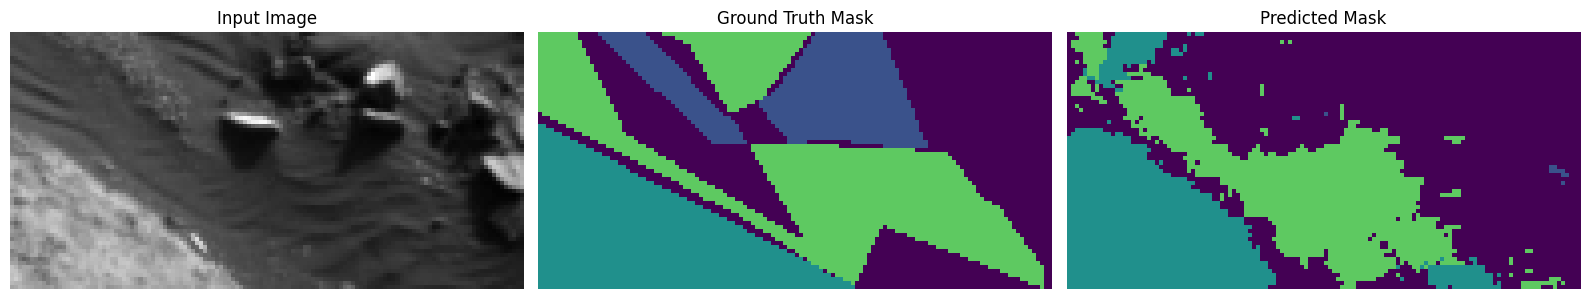

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.7956 - loss: 0.5263 - mean_iou: 0.4930 - val_accuracy: 0.7583 - val_loss: 0.6403 - val_mean_iou: 0.4548 - learning_rate: 1.0000e-05
Epoch 57/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7944 - loss: 0.5336 - mean_iou: 0.4946 - val_accuracy: 0.7568 - val_loss: 0.6451 - val_mean_iou: 0.4510 - learning_rate: 1.0000e-05
Epoch 58/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 558ms/step - accuracy: 0.7883 - loss: 0.5457 - mean_iou: 0.4865 - val_accuracy: 0.7588 - val_loss: 0.6410 - val_mean_iou: 0.4557 - learning_rate: 1.0000e-05
Epoch 59/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7931 - loss: 0.5316 - mean_iou: 0.4883 - val_accuracy: 0.7554 - val_loss: 0.6455 - val_mean_iou: 0.4505 - learning_rate: 1.0000e-05
Epoch 60/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7952 - loss: 0.5283 - mean_iou: 0.4920 - val_accuracy: 0.7572 - val_loss: 0.6431 - val_mean_iou: 0.4553 - learning_rate: 1.0000e-05
Epoc

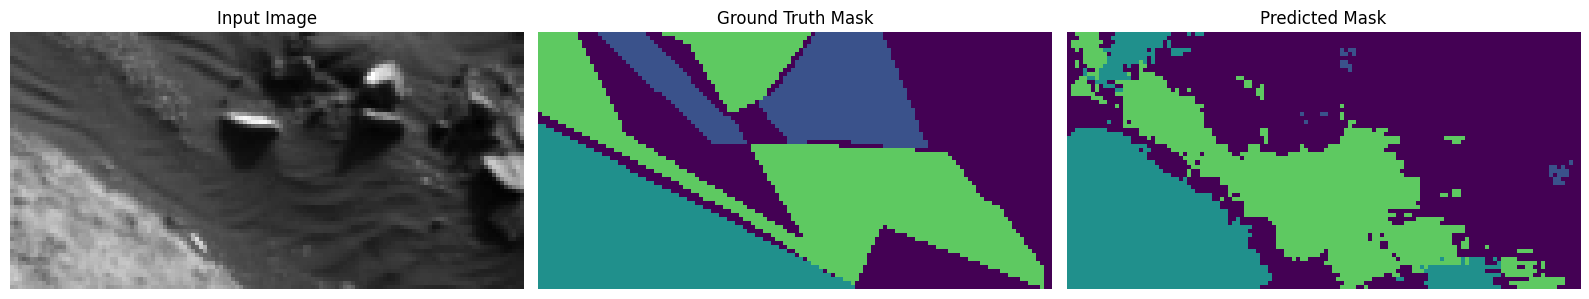

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step - accuracy: 0.7901 - loss: 0.5323 - mean_iou: 0.4851 - val_accuracy: 0.7549 - val_loss: 0.6500 - val_mean_iou: 0.4491 - learning_rate: 1.0000e-05
Epoch 62/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.7881 - loss: 0.5454 - mean_iou: 0.4889 - val_accuracy: 0.7552 - val_loss: 0.6469 - val_mean_iou: 0.4505 - learning_rate: 1.0000e-05
Epoch 63/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7940 - loss: 0.5305 - mean_iou: 0.4904 - val_accuracy: 0.7567 - val_loss: 0.6432 - val_mean_iou: 0.4517 - learning_rate: 1.0000e-05
Epoch 64/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7917 - loss: 0.5360 - mean_iou: 0.4907 - val_accuracy: 0.7576 - val_loss: 0.6412 - val_mean_iou: 0.4524 - learning_rate: 1.0000e-05
Epoch 65/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7894 - loss: 0.5436 - mean_iou: 0.4905 - val_accuracy: 0.7579 - val_loss: 0.6405 - val_mean_iou: 0.4549 - learning_rate: 1.0000e-05
Epoc

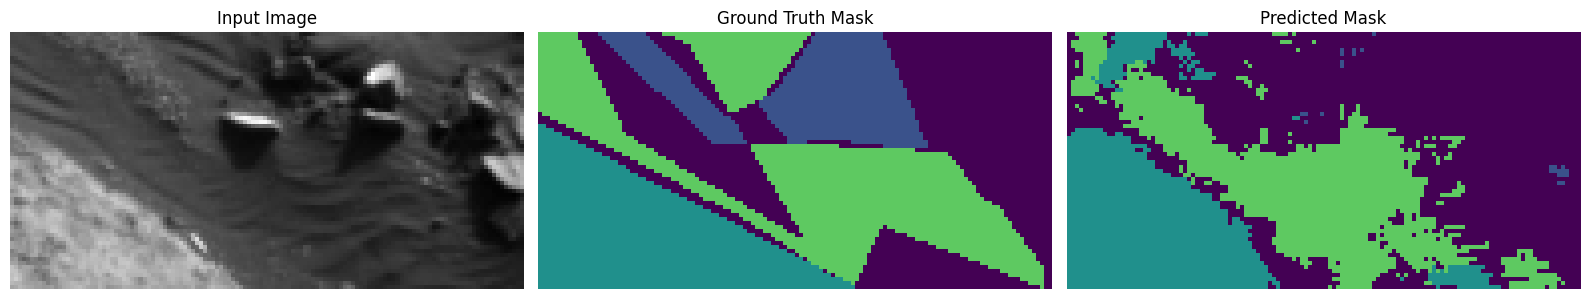

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 561ms/step - accuracy: 0.7964 - loss: 0.5223 - mean_iou: 0.4940 - val_accuracy: 0.7562 - val_loss: 0.6426 - val_mean_iou: 0.4529 - learning_rate: 1.0000e-05
Epoch 67/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7917 - loss: 0.5360 - mean_iou: 0.4900 - val_accuracy: 0.7578 - val_loss: 0.6405 - val_mean_iou: 0.4539 - learning_rate: 1.0000e-06
Epoch 68/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.8007 - loss: 0.5153 - mean_iou: 0.4978 - val_accuracy: 0.7581 - val_loss: 0.6401 - val_mean_iou: 0.4536 - learning_rate: 1.0000e-06
Epoch 69/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7948 - loss: 0.5294 - mean_iou: 0.4919 - val_accuracy: 0.7583 - val_loss: 0.6403 - val_mean_iou: 0.4542 - learning_rate: 1.0000e-06
Epoch 70/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.7958 - loss: 0.5312 - mean_iou: 0.4892 - val_accuracy: 0.7584 - val_loss: 0.6399 - val_mean_iou: 0.4536 - learning_rate: 1.0000e-06
Epoc

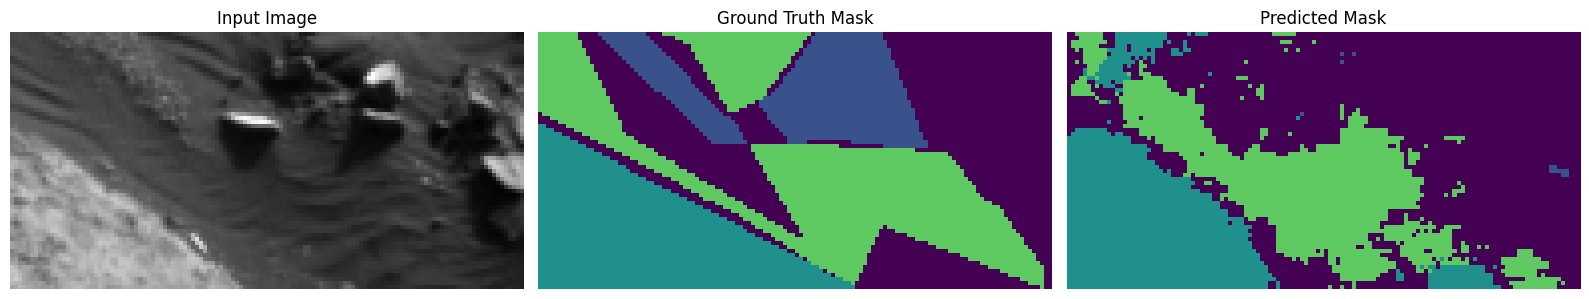

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step - accuracy: 0.7961 - loss: 0.5230 - mean_iou: 0.4968 - val_accuracy: 0.7585 - val_loss: 0.6396 - val_mean_iou: 0.4538 - learning_rate: 1.0000e-06
Epoch 72/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.7966 - loss: 0.5269 - mean_iou: 0.4988 - val_accuracy: 0.7587 - val_loss: 0.6391 - val_mean_iou: 0.4539 - learning_rate: 1.0000e-06
Epoch 73/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7948 - loss: 0.5234 - mean_iou: 0.4930 - val_accuracy: 0.7586 - val_loss: 0.6395 - val_mean_iou: 0.4535 - learning_rate: 1.0000e-06
Epoch 74/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.8013 - loss: 0.5123 - mean_iou: 0.4965 - val_accuracy: 0.7589 - val_loss: 0.6394 - val_mean_iou: 0.4536 - learning_rate: 1.0000e-06
Epoch 75/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7966 - loss: 0.5216 - mean_iou: 0.4975 - val_accuracy: 0.7586 - val_loss: 0.6400 - val_mean_iou: 0.4530 - learning_rate: 1.0000e-06
Epoc

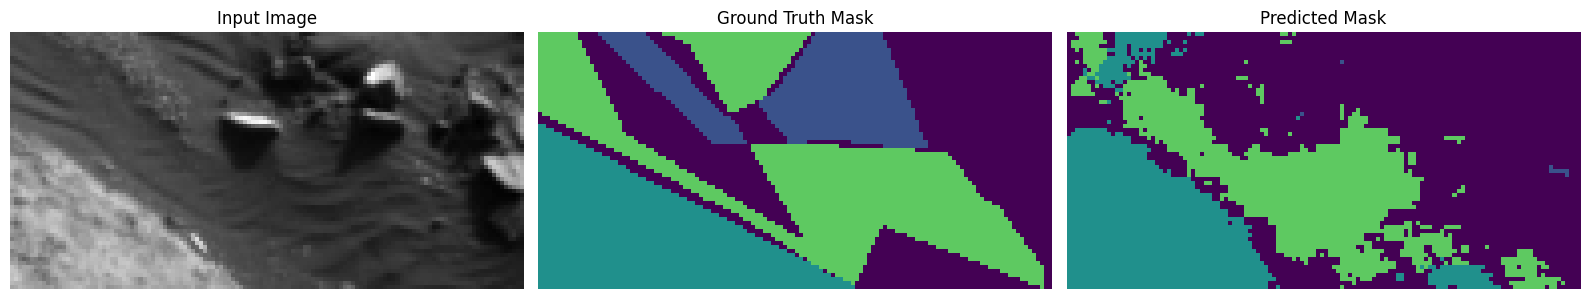

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 559ms/step - accuracy: 0.7995 - loss: 0.5170 - mean_iou: 0.4991 - val_accuracy: 0.7592 - val_loss: 0.6387 - val_mean_iou: 0.4537 - learning_rate: 1.0000e-06
Epoch 77/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.8038 - loss: 0.5082 - mean_iou: 0.5049 - val_accuracy: 0.7593 - val_loss: 0.6384 - val_mean_iou: 0.4539 - learning_rate: 1.0000e-06
Epoch 78/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.7999 - loss: 0.5161 - mean_iou: 0.5044 - val_accuracy: 0.7593 - val_loss: 0.6386 - val_mean_iou: 0.4544 - learning_rate: 1.0000e-06
Final validation Mean Intersection Over Union: 45.57%


In [24]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history["val_mean_iou"]) * 100, 2)
print(f"Final validation Mean Intersection Over Union: {final_val_meanIoU}%")

In [25]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241204_232810.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [26]:
"""
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")
"""

'\n# If model_filename is not defined, load the most recent model from Google Drive\nif "model_filename" not in globals() or model_filename is None:\n    files = [f for f in os.listdir(\'.\') if os.path.isfile(f) and f.startswith(\'model_\') and f.endswith(\'.keras\')]\n    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)\n    if files:\n        model_filename = files[0]\n    else:\n        raise FileNotFoundError("No model files found in the current directory.")\n'

In [27]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241204_232810.keras


In [28]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step


2024-12-04 23:29:17.294705: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1642004480 exceeds 10% of free system memory.


Predictions shape: (10022, 64, 128)


In [29]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [30]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# from google.colab import files
# files.download(submission_filename)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```